In [28]:
import os
import re
import emoji
import pandas as pd

from collections import Counter, defaultdict
from nltk.corpus import stopwords
from string import punctuation
from wordcloud import WordCloud 

from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
import string
import nltk
nltk.download('stopwords')
import shutil

import seaborn as sns
import matplotlib.pylab as plt

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/clairephibbs/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Loading in the Data (Violation.txt and Inspections.txt)

### Dataset Description
1. EVENT_NO (VARCHAR2): A preassigned number used to identify each inspection, investigation, audit, survey, etc.  Use event_no to join to the Inspections table which can be joined to the Mines table with mine_id.
2. INSPECTION_BEGIN_DT (DATE): Start date of the inspection (mm/dd/yyyy).
3. INSPECTION_END_DT (DATE): Inspection close out date (mm/dd/yyyy).
4. VIOLATION_NO (VARCHAR2): Citation/order number assigned to each citation written during an inspection.  This is a unique key to the file.
5. CONTROLLER_ID (VARCHAR2): Identification number assigned by MSHA Assessments for a Legal Entity acting as a controller of an operator at the time the violation was cited. May contain null values if this record pertains to a violation issued to a contractor.
6. CONTROLLER_NAME (VARCHAR2): Name of the controller active at the time the violation was cited.  May contain null values if this record pertains to a violation issued to a contractor.
7. VIOLATOR_ID (VARCHAR2): Identification number assigned by MSHA for a Legal Entity acting as an operator at a mine at the time the violation was cited. May contain null values if this record pertains to a violation issued to a contractor.
8. VIOLATOR_NAME (VARCHAR2): Name of the operator active at the time the violation was cited.  May contain null values if this record pertains to a violation issued to a contractor.
9. VIOLATOR_TYPE_CD (VARCHAR2): Each Violator record represents an entity (Operator, Contractor, Agent or Miner) that has one or more violations at a mine.
10. MINE_ID (VARCHAR2): Mine id of the mine where the violation was issued.  Can use the mine_id to join to the Mines table.  
11. MINE_NAME (VARCHAR2): Name of the mine where the violation was issued.
12. MINE_TYPE (VARCHAR2): Mine type of the mine where the violation has been issued:  Facility, Surface or Underground.
13. COAL_METAL_IND (VARCHAR2): Identifies if the record is for a Coal or Metal/Non-Metal mine.
14. CONTRACTOR_ID (VARCHAR2): Code identifying the contractor to whom the citation or order was issued.  May contain null values if the contractor was not cited.
15. VIOLATION_ISSUE_DT (DATE): Date the citation or order was issued by the MSHA inspector.
16. VIOLATION_OCCUR_DT (DATE): Actual date of occurrence of the violation.  
17. CAL_YR (NUMBER): Calendar year during which the citation/order was issued by the MSHA inspector.
18. CAL_QTR (NUMBER): Calendar Quarter of the date the citation or order was issued by the MSHA inspector.
19. FISCAL_YR (NUMBER): Fiscal Year of the date the citation or order was issued by the MSHA inspector.  MSHA's fiscal year begins October 1 and ends September 30.
20. FISCAL_QTR (NUMBER): Fiscal Quarter of the date the citation or order was issued by the MSHA inspector.
21. VIOLATION_ISSUE_TIME (VARCHAR2): Time (24 hour) the citation or order was issued by the MSHA inspector.
22. SIG_SUB (VARCHAR2): An indicator as to whether or not the gravity is determined by the inspector to be significant and substantial.  If this is 'Y', the inspector has indicated that based upon the particular facts surrounding the violation there exists a reasonable likelihood the hazard contributed to will result in an injury or illness of a reasonably serious nature.
23. SECTION_OF_ACT (VARCHAR2): Section of the Act under which the citation/order was issued.  May contain null values.
24. PART_SECTION (VARCHAR2): Code of Federal Regulations: Part/section of Title 30 CFR violated in format PPSSSSSXXXX where (P) Part, (S) Section and (X) Suffix.  Four-digit section numbers are expanded to five within one leading zero.  May contain null values.
25. SECTION_OF_ACT_1 (VARCHAR2): Primary Section of Act which gives the MSHA Inspector the authority to take the action specified by this Issuance.   More than one type of action may be cited.
26. SECTION_OF_ACT_2 (VARCHAR2): Secondary Section of Act which gives the MSHA Inspector the authority to take the action specified by this Issuance at Metal/Non-Metal mines only.  More than one type of action may be cited.
27. CIT_ORD_SAFE (VARCHAR2): Specifies the type of Citation: Citation, Order, Safeguard, Written Notice or Notice.
28. ORIG_TERM_DUE_DT (DATE): Original date by which the cited condition was to be abated.  Original time by which the cited condition was to be abated. 
29. ORIG_TERM_DUE_TIME (VARCHAR2): Original time by which the cited condition was to be abated.   
30. LATEST_TERM_DUE_DT (DATE): Date by which the conditions cited in the citation/order are to be abated.  For Metal mines, this can be the termination due date to which the citation/order is extended.  
31. LATEST_TERM_DUE_TIME (VARCHAR2): Time by which the conditions cited on the citation/order are to be abated.  
32. TERMINATION_DT (DATE): Date on which the citation/order was terminated.  May contain null values if citation has not yet been terminated.
33. TERMINATION_TIME (VARCHAR2): Time of day (24 hour) at which the citation/order was terminated.  May contain null values if citation has not yet been terminated.
34. TERMINATION_TYPE (VARCHAR2): Code identifying the type of termination:  Issued, ReplacedByOrder or Terminated.
35. VACATE_DT (DATE): Date on which the citation/order was vacated.  May contain null values if the violation was not vacated.
36. VACATE_TIME (VARCHAR2): Time of day (24 hour) at which the citation/order was vacated.  May contain null values if the violation was not vacated.
37. INITIAL_VIOL_NO (VARCHAR2): This is the preceding citation record when there is a need to relate a citation to a previous one. For example this would apply when an order follows a citation. This relationship is needed to calculate the good faith reduction penalty points.  May contain null values.
38. REPLACED_BY_ORDER_NO (VARCHAR2): Order number which replaced the original citation.  May contain null values if situation does not apply.
39. LIKELIHOOD (VARCHAR2): This is a measure of the seriousness of the violation being cited as measured by the likelihood of the occurrence of an accident:  Highly, NoLikelihood, Occurred, Reasonably or Unlikely. May contain null values if situation does not apply.
40. INJ_ILLNESS (VARCHAR2): Value assigned to a violation for gravity of injury.  Measure of seriousness of violation being cited as measured by severity of the injury or illness to persons if accident were to occur due to the conditions of the violation: Fatal, LostDays, NoLostDays or Permanent.
41. NO_AFFECTED (NUMBER): This is a measure of the number of persons affected or potentially affected by the conditions at the Mine due to the violation.  Can be zero.
42. NEGLIGENCE (VARCHAR2): Codes representing the degree of negligence that the Inspector assigned to the violator due to the violation:  HighNegligence, LowNegligence, ModNegligence, NoNegligence or Reckless. A high degree of negligence is assigned when the operator was in a position to be aware of the condition that contributed to a dangerous situation and there were no mitigating circumstances, or if there are unique aggravating circumstances associated with the violation, such as repeated past violations of the same standard at the mine.
43. WRITTEN_NOTICE (VARCHAR2): Indicates if this citation is a result of a Miner or Agent notice of complaint to MSHA (written notice 103(g)):  ('Y'  or 'N').  May contain null values.
44. ENFORCEMENT_AREA (VARCHAR2): Specifies the enforcement areas affected by the violating condition or practice constitute a health hazard, safety hazard, both or other type of hazard. May contain null values.
45. SPECIAL_ASSESS (VARCHAR2): Specifies whether this citation has been designated for Special Assessment based on Special Assessment Review (Y or N).
46. PRIMARY_OR_MILL (VARCHAR2): A code indicating if the Violation was observed in the Primary Mine location or in an associated Mill (Metal/Non-Metal only). May contain null values.
47. RIGHT_TO_CONF_DT (DATE): Date the operator was advised of his right to a conference (Metal/Non-Metal only).  May contain null values.
48. ASMT_GENERATED_IND (VARCHAR2): If the violator is an Operator or Contractor, the indicator is 'N'. If the violator is an Agent, the indicator is 'Y'. If the violator is a Miner, the indicator can be 'Y' or 'N'. If none of the above, the indicator is '?'.
49. FINAL_ORDER_ISSUE_DT (DATE): Date that this assessment becomes a Final Order.  This date is set when the Certified Return Receipt date (CRR) is set.  Note that this can be a projected future date that is set as soon as the CRR is entered.  
50. PROPOSED_PENALTY (NUMBER): The original dollar value of the proposed penalty prior to any modifications such as those possibly resulting from a decision on a contested case.
51. AMOUNT_DUE (NUMBER): The current dollar value of the proposed assessment, reflecting any modifications that have been made since it was originally assessed.
52. AMOUNT_PAID (NUMBER): The total dollar value of all payments applied to this proposed assessment to date.
53. BILL_PRINT_DT (DATE): Date the bill was printed.  This date always represents the first time the bill was printed.
54. LAST_ACTION_CD (VARCHAR2): Last action taken against this violation such as 1stDemandPrinted, BillingReady, ApprovedforTreasury and Proposed.  
55. LAST_ACTION_DT (DATE): Date the last action taken against this violation.
56. DOCKET_NO (VARCHAR2): The Docket Number assigned by the Court to this group of Assessments being contested.
57. DOCKET_STATUS_CD (VARCHAR2): Denotes the current status of this docket:  Approved (approved by the court) or Proposed (not yet been approved by the court).
58. CONTESTED_IND (VARCHAR2): Indicates if this violation has been assessed and is being contested (Y or N).
59. CONTESTED_DT (DATE): Date of the most recent docket status for this violation.
60. VIOLATOR_VIOLATION_CNT (NUMBER): Total number of assessed violations for this violator at this time during the violation history period. Used in penalty calculation.  Applies to an Operator or a Contractor.
61. VIOLATOR_INSPECTION_DAY_CNT (NUMBER): Total number of inspections for this Operator at a mine during the violation history period. Used in penalty calculation. Does not apply to Contractor.

In [31]:
violations = pd.read_csv('/users/clairephibbs/Desktop/Violations.txt', sep= '|', encoding = 'latin-1')
inspections = pd.read_csv('/users/clairephibbs/Desktop/Inspections.txt', sep= '|', encoding = 'latin-1')
display(violations)

/var/folders/pf/065skph15m56xshv4vk3x09m0000gn/T/ipykernel_19752/2999520160.py:1: DtypeWarning: Columns (25,34,36,37,43,45,46,55,56,58) have mixed types. Specify dtype option on import or set low_memory=False.
  violations = pd.read_csv('/users/clairephibbs/Desktop/Violations.txt', sep= '|', encoding = 'latin-1')


,EVENT_NO,INSPECTION_BEGIN_DT,INSPECTION_END_DT,VIOLATION_NO,CONTROLLER_ID,CONTROLLER_NAME,VIOLATOR_ID,VIOLATOR_NAME,VIOLATOR_TYPE_CD,MINE_ID,...,AMOUNT_PAID,BILL_PRINT_DT,LAST_ACTION_CD,LAST_ACTION_DT,DOCKET_NO,DOCKET_STATUS_CD,CONTESTED_IND,CONTESTED_DT,VIOLATOR_VIOLATION_CNT,VIOLATOR_INSPECTION_DAY_CNT
0,711256,01/04/2000,01/07/2000,6089192,0041044,Lhoist Group,L13586,"Lhoist North America of Alabama, LLC",Operator,100003,...,55.0,12/04/2000,Paid,01/08/2001,NaN,NaN,N,NaN,0.0,0.0
1,711256,01/04/2000,01/07/2000,6089193,0041044,Lhoist Group,L13586,"Lhoist North America of Alabama, LLC",Operator,100003,...,55.0,12/04/2000,Paid,01/08/2001,NaN,NaN,N,NaN,0.0,0.0
2,711256,01/04/2000,01/07/2000,6089194,0041044,Lhoist Group,L13586,"Lhoist North America of Alabama, LLC",Operator,100003,...,55.0,12/04/2000,Paid,01/08/2001,NaN,NaN,N,NaN,0.0,0.0
3,711256,01/04/2000,01/07/2000,6089195,0041044,Lhoist Group,L13586,"Lhoist North America of Alabama, LLC",Operator,100003,...,196.0,12/04/2000,Paid,01/08/2001,NaN,NaN,N,NaN,0.0,0.0
4,711256,01/04/2000,01/07/2000,6089196,0041044,Lhoist Group,L13586,"Lhoist North America of Alabama, LLC",Operator,100003,...,55.0,12/04/2000,Paid,01/08/2001,NaN,NaN,N,NaN,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2812752,6644004,12/10/2012,12/13/2012,8727304,0042611,Ann E Abramson,0051892,Aggregate Inc,Operator,5500013,...,2282.0,02/05/2013,Paid,11/24/2015,NaN,NaN,N,NaN,14.0,5.0
2812753,6644004,12/10/2012,12/13/2012,8727305,0042611,Ann E Abramson,0051892,Aggregate Inc,Operator,5500013,...,460.0,02/05/2013,Paid,01/20/2016,NaN,NaN,N,NaN,14.0,5.0
2812754,6644004,12/10/2012,12/13/2012,8727306,0042611,Ann E Abramson,0051892,Aggregate Inc,Operator,5500013,...,207.0,02/05/2013,Paid,11/24/2015,NaN,NaN,N,NaN,14.0,6.0
2812755,6644004,12/10/2012,12/13/2012,8727307,0042611,Ann E Abramson,0051892,Aggregate Inc,Operator,5500013,...,127.0,02/05/2013,Paid,05/20/2014,NaN,NaN,N,NaN,14.0,6.0


## EDA (Exploratory Data Analysis)

In [154]:
controller_valuecounts = violations['CONTROLLER_NAME'].value_counts()
controller_valuecounts_filtered = controller_valuecounts[controller_valuecounts >= 1000]
controller_valuecounts_filtered

CONTROLLER_NAME
CONSOL Energy Inc                  85575
Massey Energy Company              79622
Alpha Natural Resources, Inc.      66628
Alliance Resource Partners LP      62528
Robert E  Murray                   60291
                                   ...  
Wilma  Wagner                       1017
Estate of Henry T. Southway Jr.     1015
David  Stevenson                    1015
James P  Jurgensen                  1005
Fred Weber, Inc.                    1001
Name: count, Length: 300, dtype: int64

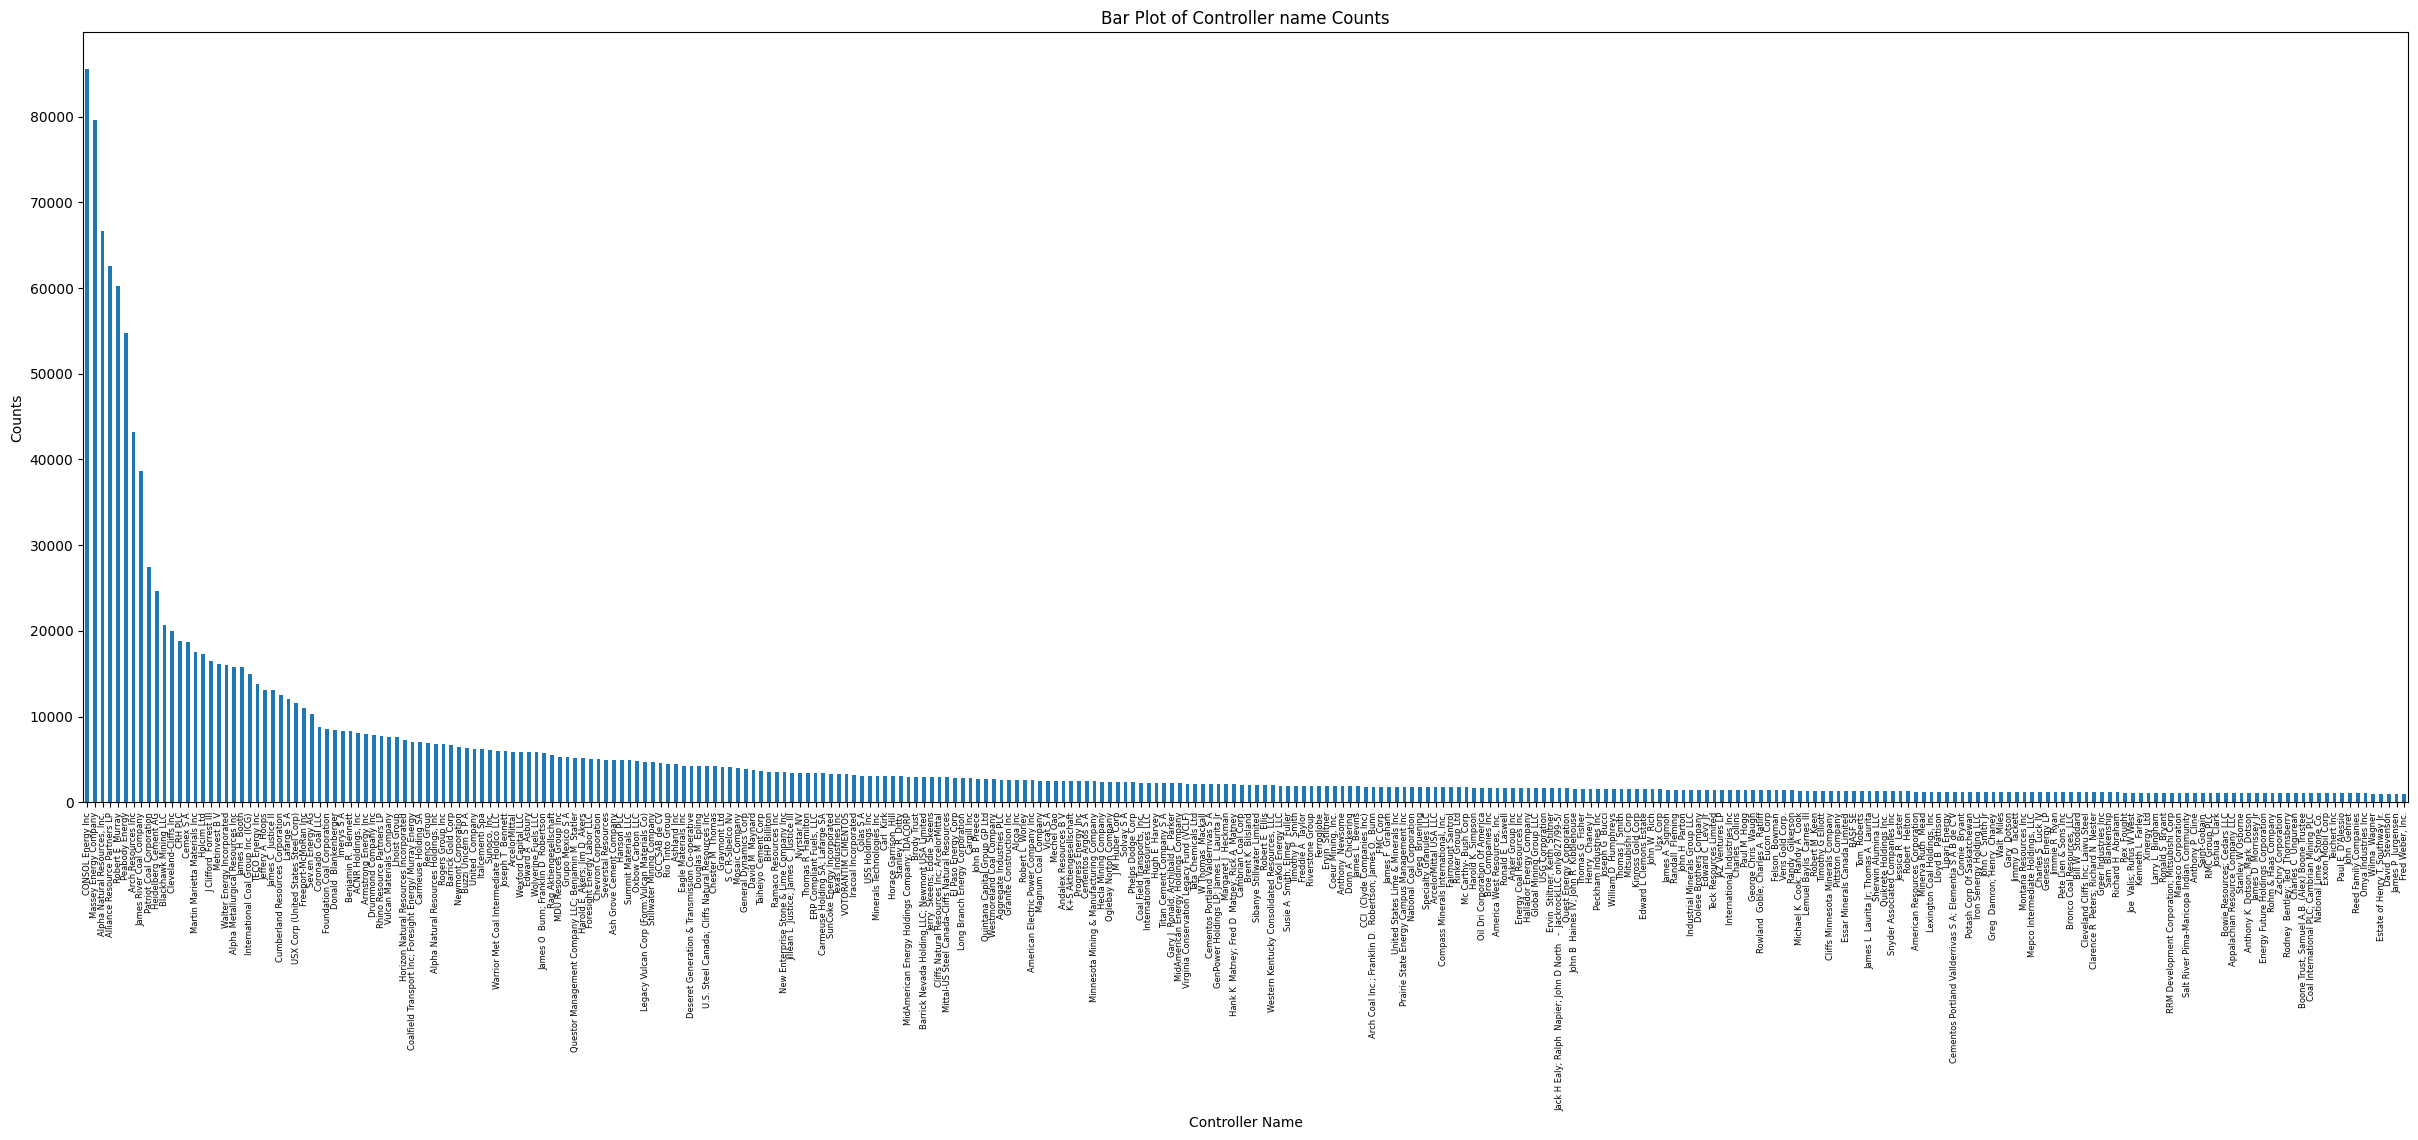

In [157]:
## adjusted to only show controller_names with more than 1000 violations (as they are the more problamatic controllers and to make the visual more readable)
# controller_name bar chart
plt.figure(figsize = (30,10))
controller_valuecounts_filtered.plot(kind = 'bar')
plt.xlabel('Controller Name')
plt.ylabel('Counts')
plt.title('Bar Plot of Controller name Counts')
plt.tick_params(axis = 'x', labelsize = 6)


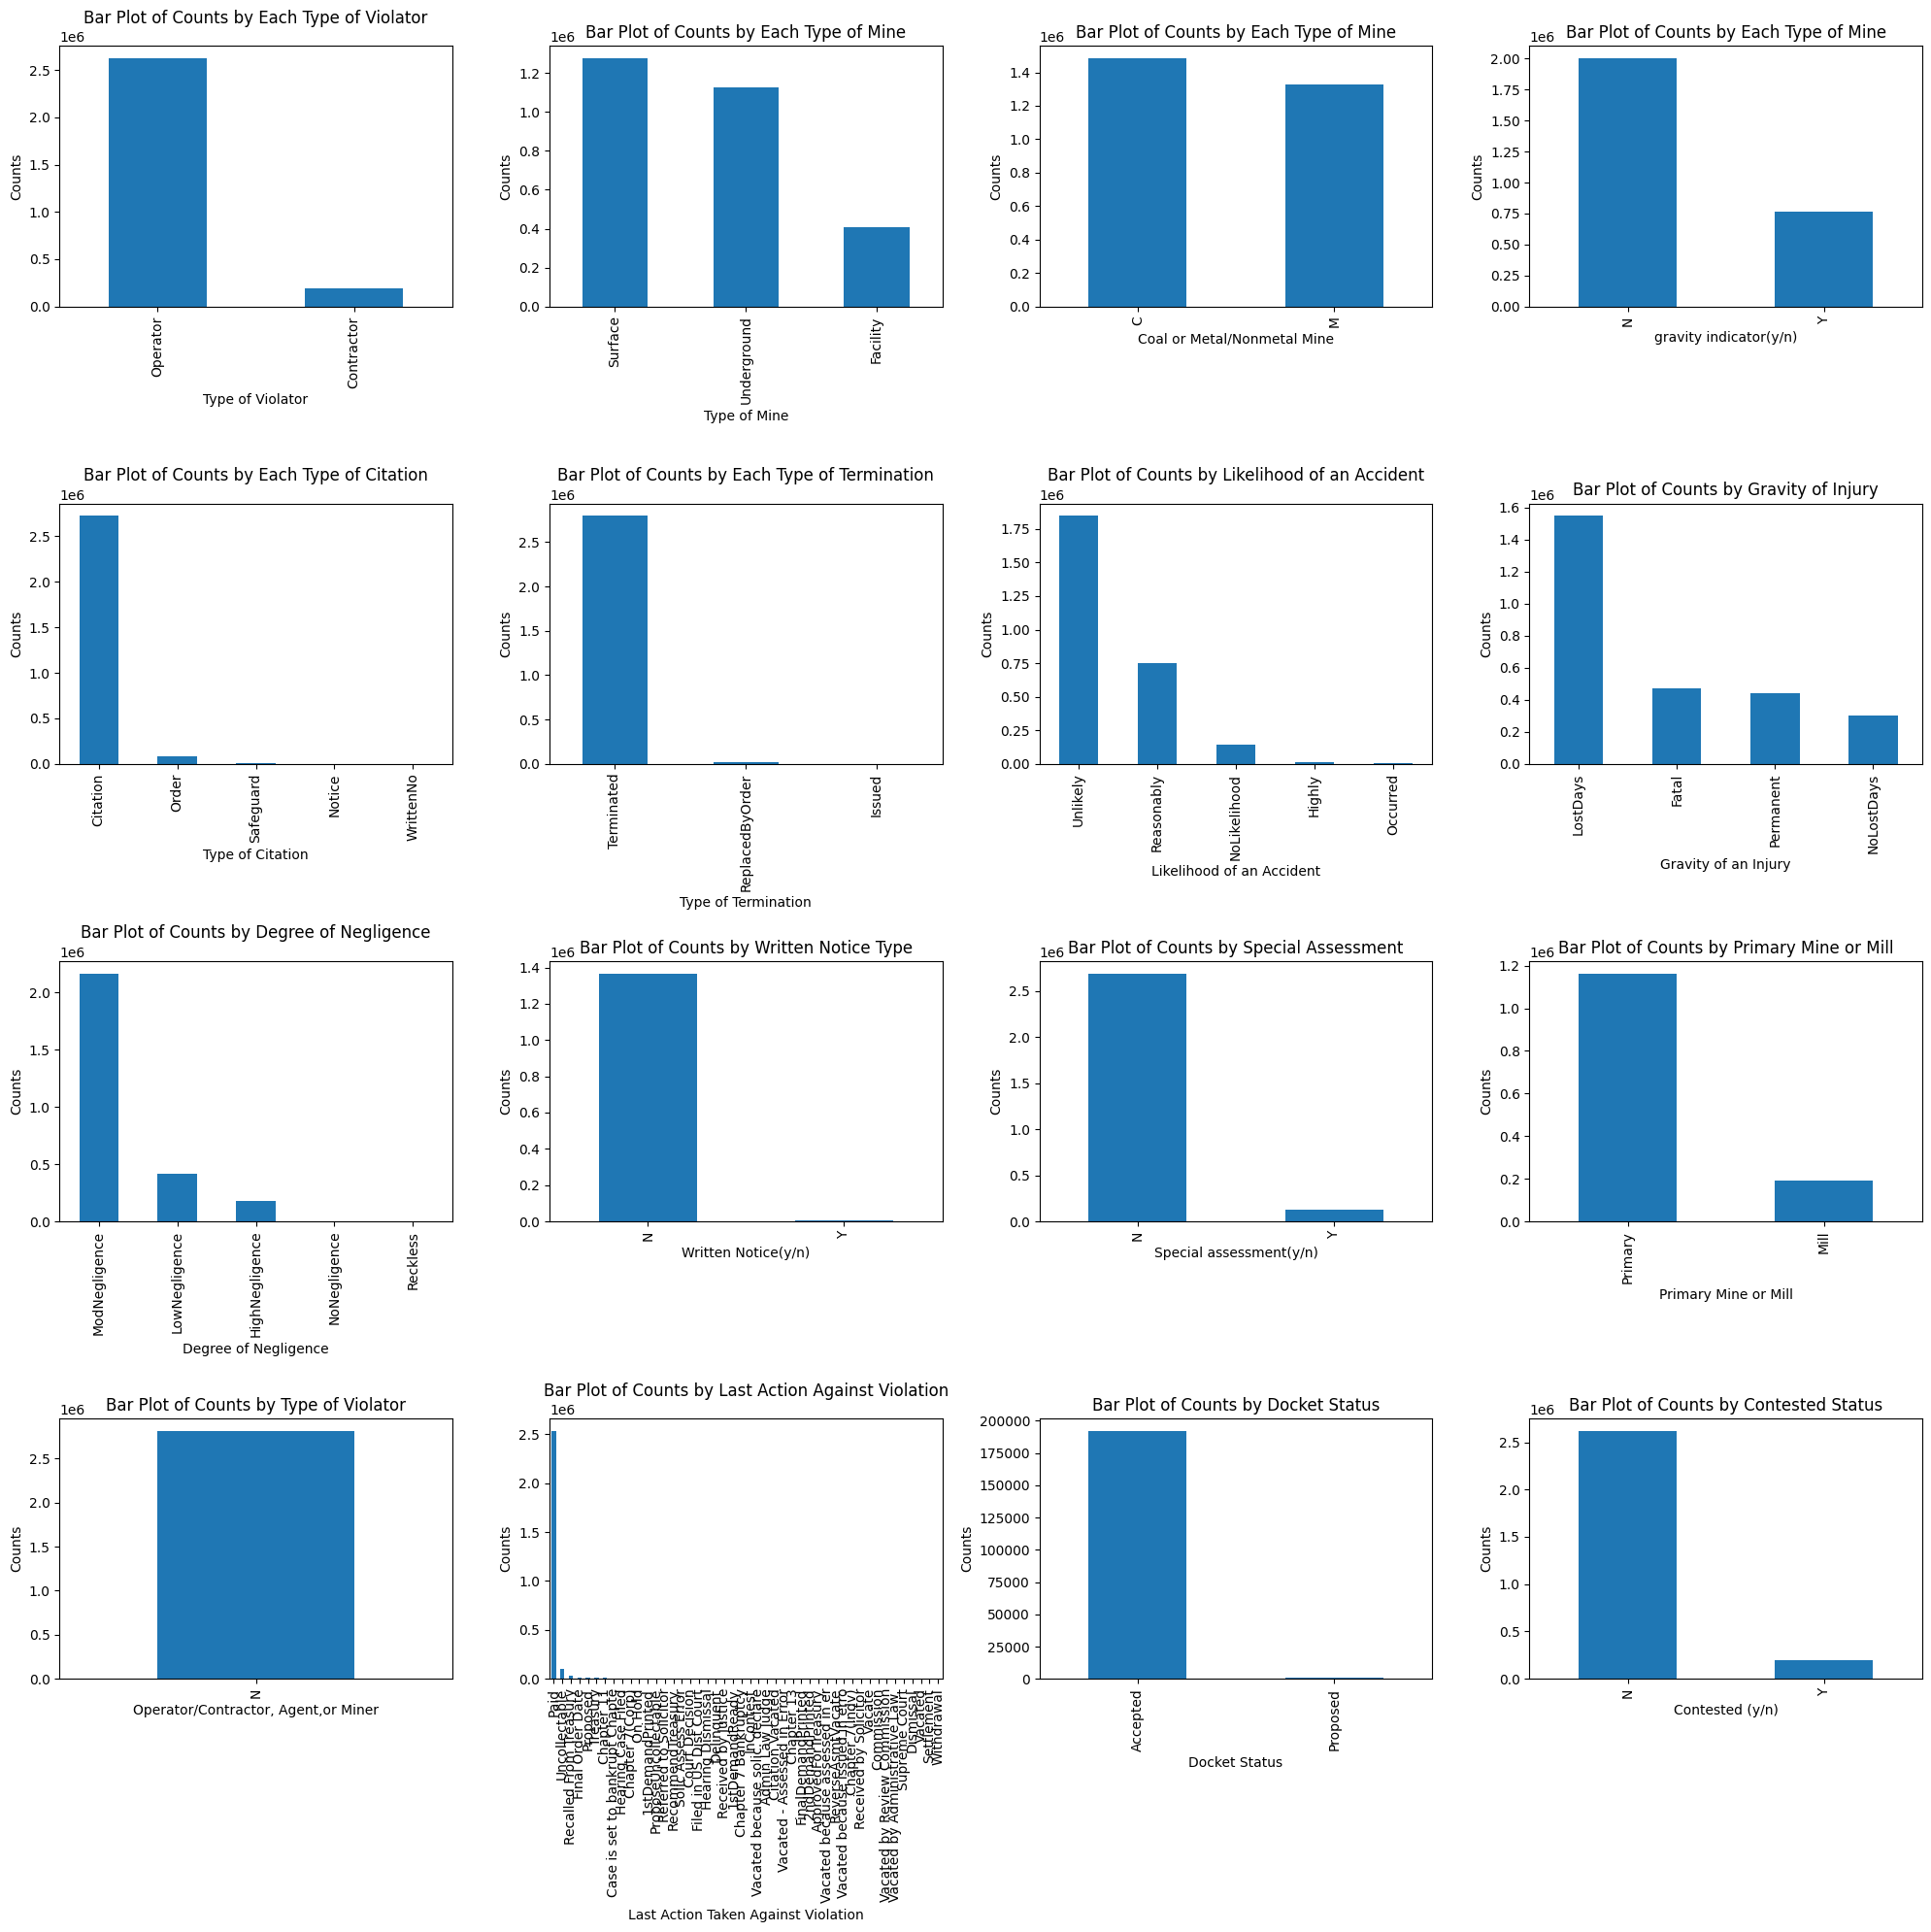

In [101]:
# bar plots of categorical and binary variables in violations df

fig, axs = plt.subplots(4, 4, figsize = (20, 20))

# violator_type_cd bar chart
violations['VIOLATOR_TYPE_CD'].value_counts().plot(kind = 'bar', ax = axs[0,0])
axs[0,0].set_xlabel('Type of Violator')
axs[0,0].set_ylabel('Counts')
axs[0,0].set_title('Bar Plot of Counts by Each Type of Violator')

# mine_type bar chart
violations['MINE_TYPE'].value_counts().plot(kind = 'bar', ax = axs[0,1])
axs[0,1].set_xlabel('Type of Mine')
axs[0,1].set_ylabel('Counts')
axs[0,1].set_title('Bar Plot of Counts by Each Type of Mine')

# coal_metal_ind bar chart
violations['COAL_METAL_IND'].value_counts().plot(kind = 'bar', ax = axs[0,2])
axs[0,2].set_xlabel('Coal or Metal/Nonmetal Mine')
axs[0,2].set_ylabel('Counts')
axs[0,2].set_title('Bar Plot of Counts by Each Type of Mine')

# Sig_sub bar chart
violations['SIG_SUB'].value_counts().plot(kind = 'bar', ax = axs[0,3])
axs[0,3].set_xlabel('gravity indicator(y/n)')
axs[0,3].set_ylabel('Counts')
axs[0,3].set_title('Bar Plot of Counts by Each Type of Mine')

# city_ord_safe bar chart
violations['CIT_ORD_SAFE'].value_counts().plot(kind = 'bar', ax = axs[1,0])
axs[1,0].set_xlabel('Type of Citation')
axs[1,0].set_ylabel('Counts')
axs[1,0].set_title('Bar Plot of Counts by Each Type of Citation')

# termination_type bar chart
violations['TERMINATION_TYPE'].value_counts().plot(kind = 'bar', ax = axs[1,1])
axs[1,1].set_xlabel('Type of Termination')
axs[1,1].set_ylabel('Counts')
axs[1,1].set_title('Bar Plot of Counts by Each Type of Termination')

# likelihood bar chart
violations['LIKELIHOOD'].value_counts().plot(kind = 'bar', ax = axs[1,2])
axs[1,2].set_xlabel('Likelihood of an Accident')
axs[1,2].set_ylabel('Counts')
axs[1,2].set_title('Bar Plot of Counts by Likelihood of an Accident')

# inJ_illness bar chart
violations['INJ_ILLNESS'].value_counts().plot(kind = 'bar', ax = axs[1,3])
axs[1,3].set_xlabel('Gravity of an Injury')
axs[1,3].set_ylabel('Counts')
axs[1,3].set_title('Bar Plot of Counts by Gravity of Injury')

# negligence bar chart
violations['NEGLIGENCE'].value_counts().plot(kind = 'bar', ax = axs[2,0])
axs[2,0].set_xlabel('Degree of Negligence')
axs[2,0].set_ylabel('Counts')
axs[2,0].set_title('Bar Plot of Counts by Degree of Negligence')

# written_notice bar chart
violations['WRITTEN_NOTICE'].value_counts().plot(kind = 'bar', ax = axs[2,1])
axs[2,1].set_xlabel('Written Notice(y/n)')
axs[2,1].set_ylabel('Counts')
axs[2,1].set_title('Bar Plot of Counts by Written Notice Type')

# enforcement_area bar chart
violations['ENFORCEMENT_AREA'].value_counts().plot(kind = 'bar', ax = axs[2,2])
axs[2,2].set_xlabel('Enforcement Area Affected')
axs[2,2].set_ylabel('Counts')
axs[2,2].set_title('Bar Plot of Counts by Enforcement Area Affected')

# special_assess bar chart
violations['SPECIAL_ASSESS'].value_counts().plot(kind = 'bar', ax = axs[2,2])
axs[2,2].set_xlabel('Special assessment(y/n)')
axs[2,2].set_ylabel('Counts')
axs[2,2].set_title('Bar Plot of Counts by Special Assessment')

# primary_or_mill bar chart
violations['PRIMARY_OR_MILL'].value_counts().plot(kind = 'bar', ax = axs[2,3])
axs[2,3].set_xlabel('Primary Mine or Mill')
axs[2,3].set_ylabel('Counts')
axs[2,3].set_title('Bar Plot of Counts by Primary Mine or Mill')

# asmt_generated_ind bar chart
violations['ASMT_GENERATED_IND'].value_counts().plot(kind = 'bar', ax = axs[3,0])
axs[3,0].set_xlabel('Operator/Contractor, Agent,or Miner')
axs[3,0].set_ylabel('Counts')
axs[3,0].set_title('Bar Plot of Counts by Type of Violator')

# last_action_cd bar chart
violations['LAST_ACTION_CD'].value_counts().plot(kind = 'bar', ax = axs[3,1])
axs[3,1].set_xlabel('Last Action Taken Against Violation')
axs[3,1].set_ylabel('Counts')
axs[3,1].set_title('Bar Plot of Counts by Last Action Against Violation')

# docket_status_cd bar chart
violations['DOCKET_STATUS_CD'].value_counts().plot(kind = 'bar', ax = axs[3,2])
axs[3,2].set_xlabel('Docket Status')
axs[3,2].set_ylabel('Counts')
axs[3,2].set_title('Bar Plot of Counts by Docket Status')

# contested_ind bar chart
violations['CONTESTED_IND'].value_counts().plot(kind = 'bar', ax = axs[3,3])
axs[3,3].set_xlabel('Contested (y/n)')
axs[3,3].set_ylabel('Counts')
axs[3,3].set_title('Bar Plot of Counts by Contested Status')

plt.tight_layout()
plt.show()

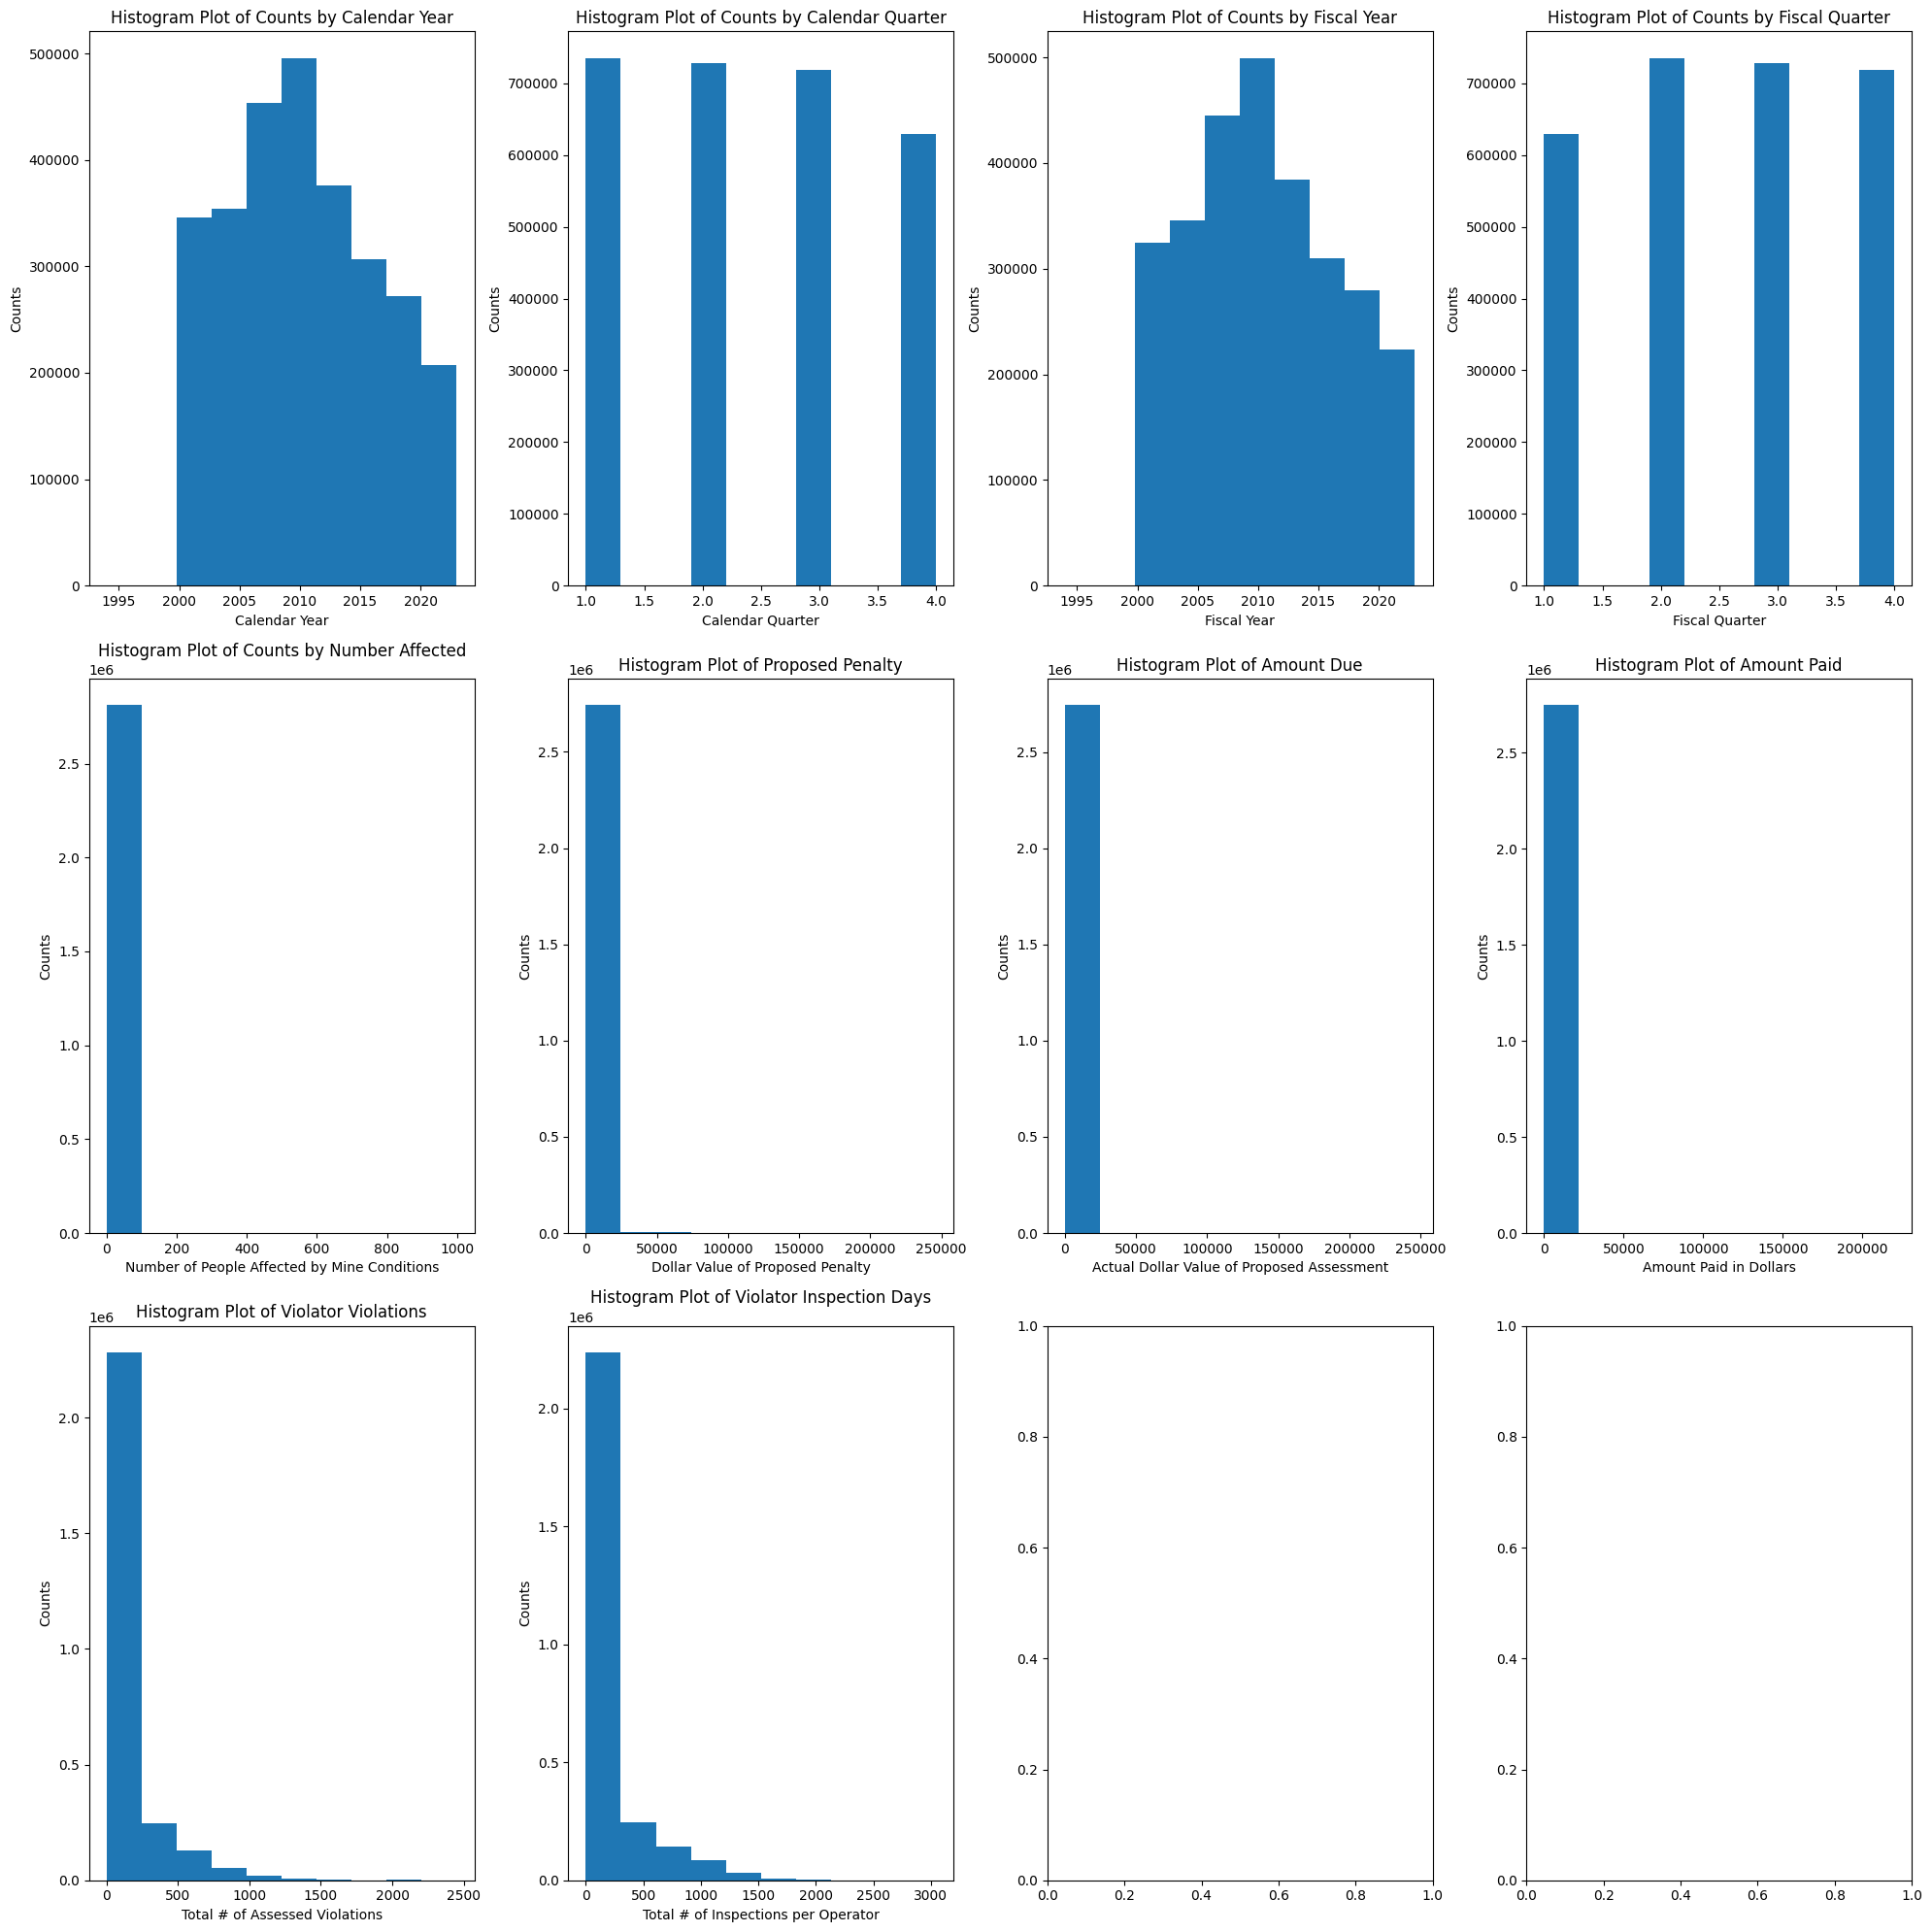

In [123]:
# scatter plots of numberical variables in violations df

fig, axs = plt.subplots(3, 4, figsize = (20, 20))

# cal_yr histogram
axs[0,0].hist(violations['CAL_YR'])
axs[0,0].set_xlabel('Calendar Year')
axs[0,0].set_ylabel('Counts')
axs[0,0].set_title('Histogram Plot of Counts by Calendar Year')

# cal_qtr histogram
axs[0,1].hist(violations['CAL_QTR'])
axs[0,1].set_xlabel('Calendar Quarter')
axs[0,1].set_ylabel('Counts')
axs[0,1].set_title('Histogram Plot of Counts by Calendar Quarter')

# fiscal_yr histogram
axs[0,2].hist(violations['FISCAL_YR'])
axs[0,2].set_xlabel('Fiscal Year')
axs[0,2].set_ylabel('Counts')
axs[0,2].set_title('Histogram Plot of Counts by Fiscal Year')

# fiscal_qtr histogram
axs[0,3].hist(violations['FISCAL_QTR'])
axs[0,3].set_xlabel('Fiscal Quarter')
axs[0,3].set_ylabel('Counts')
axs[0,3].set_title('Histogram Plot of Counts by Fiscal Quarter')

# no_affected histogram
axs[1,0].hist(violations['NO_AFFECTED'])
axs[1,0].set_xlabel('Number of People Affected by Mine Conditions')
axs[1,0].set_ylabel('Counts')
axs[1,0].set_title('Histogram Plot of Counts by Number Affected')

# proposed_penalty histogram
axs[1,1].hist(violations['PROPOSED_PENALTY'])
axs[1,1].set_xlabel('Dollar Value of Proposed Penalty')
axs[1,1].set_ylabel('Counts')
axs[1,1].set_title('Histogram Plot of Proposed Penalty')

# amount_due histogram
axs[1,2].hist(violations['AMOUNT_DUE'])
axs[1,2].set_xlabel('Actual Dollar Value of Proposed Assessment')
axs[1,2].set_ylabel('Counts')
axs[1,2].set_title('Histogram Plot of Amount Due')

# amount_paid histogram
axs[1,3].hist(violations['AMOUNT_PAID'])
axs[1,3].set_xlabel('Amount Paid in Dollars')
axs[1,3].set_ylabel('Counts')
axs[1,3].set_title('Histogram Plot of Amount Paid')

# violator_violation_cnt histogram
axs[2,0].hist(violations['VIOLATOR_VIOLATION_CNT'])
axs[2,0].set_xlabel('Total # of Assessed Violations')
axs[2,0].set_ylabel('Counts')
axs[2,0].set_title('Histogram Plot of Violator Violations')

# violator_inspection_day_cnt histogram
axs[2,1].hist(violations['VIOLATOR_INSPECTION_DAY_CNT'])
axs[2,1].set_xlabel('Total # of Inspections per Operator')
axs[2,1].set_ylabel('Counts')
axs[2,1].set_title('Histogram Plot of Violator Inspection Days')

plt.tight_layout()
plt.show()

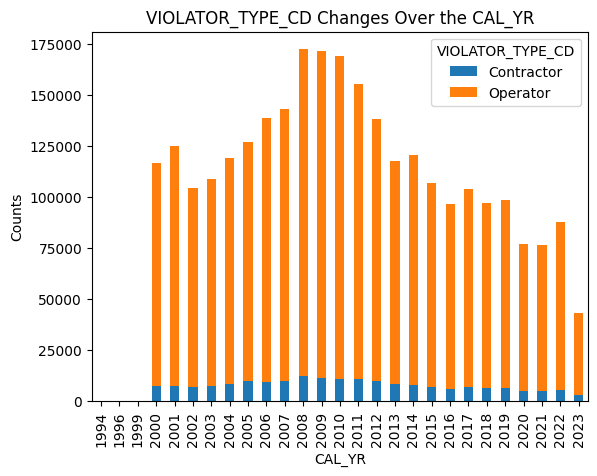

In [129]:
# Calculate value counts of VIOLATOR_TYPE_CD for each year
value_counts = violations.groupby('CAL_YR')['VIOLATOR_TYPE_CD'].value_counts().unstack()

# Create a bar plot
value_counts.plot(kind='bar', stacked=True)

# Set the x-axis label
plt.xlabel('CAL_YR')

# Set the y-axis label
plt.ylabel('Counts')

# Set the title
plt.title('VIOLATOR_TYPE_CD Changes Over the CAL_YR')

# Display the plot
plt.show()

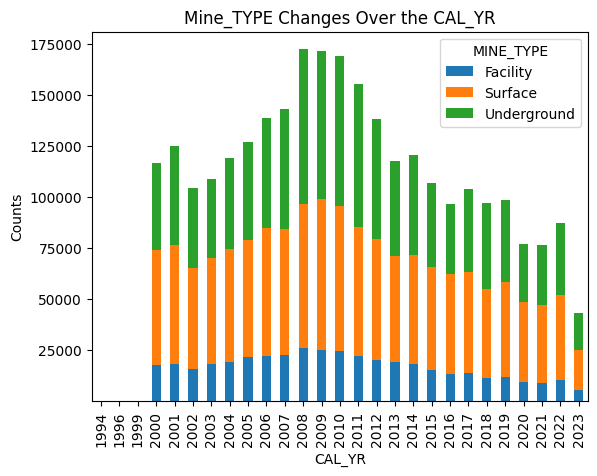

In [126]:
# Calculate value counts of MINE_TYPE for each year
value_counts = violations.groupby('CAL_YR')['MINE_TYPE'].value_counts().unstack()

# Create a bar plot
value_counts.plot(kind='bar', stacked=True)

# Set the x-axis label
plt.xlabel('CAL_YR')

# Set the y-axis label
plt.ylabel('Counts')

# Set the title
plt.title('Mine_TYPE Changes Over the CAL_YR')

# Display the plot
plt.show()

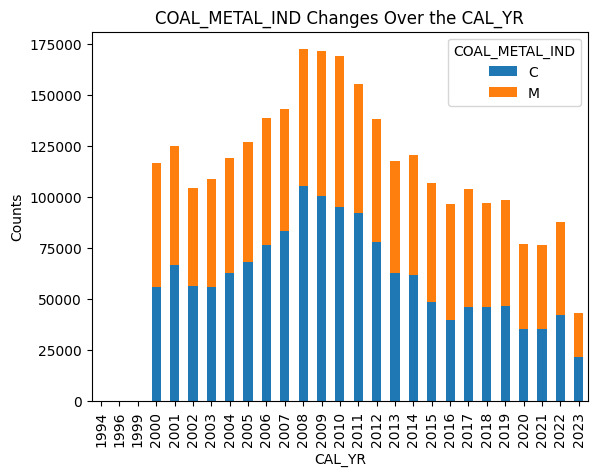

In [130]:
# Calculate value counts of COAL_METAL_IND for each year
value_counts = violations.groupby('CAL_YR')['COAL_METAL_IND'].value_counts().unstack()

# Create a bar plot
value_counts.plot(kind='bar', stacked=True)

# Set the x-axis label
plt.xlabel('CAL_YR')

# Set the y-axis label
plt.ylabel('Counts')

# Set the title
plt.title('COAL_METAL_IND Changes Over the CAL_YR')

# Display the plot
plt.show()

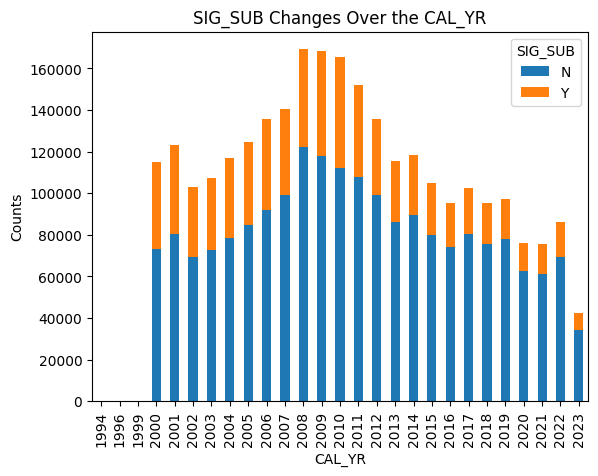

In [131]:
# Calculate value counts of SIG_SUB for each year
value_counts = violations.groupby('CAL_YR')['SIG_SUB'].value_counts().unstack()

# Create a bar plot
value_counts.plot(kind='bar', stacked=True)

# Set the x-axis label
plt.xlabel('CAL_YR')

# Set the y-axis label
plt.ylabel('Counts')

# Set the title
plt.title('SIG_SUB Changes Over the CAL_YR')

# Display the plot
plt.show()

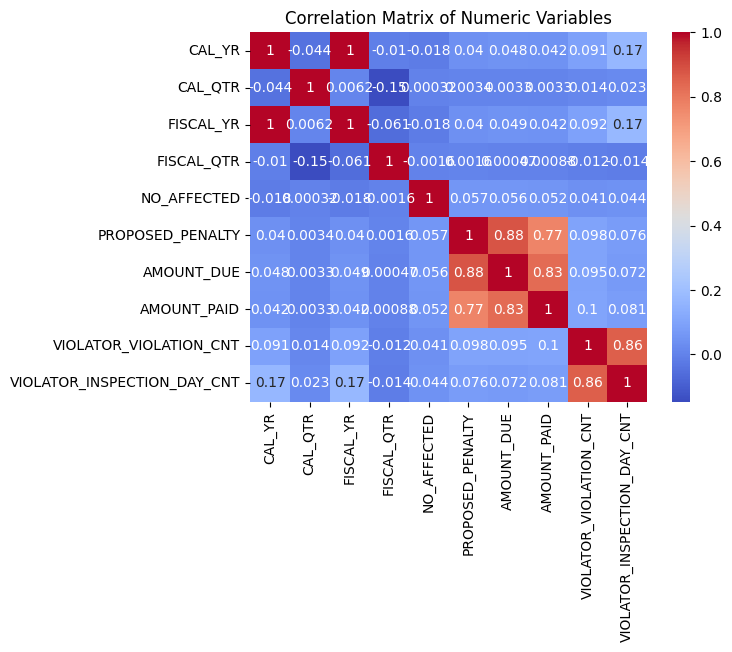

In [127]:
# correlation of numeric variables

numeric_vars = violations[['CAL_YR', 'CAL_QTR', 'FISCAL_YR', 'FISCAL_QTR', 'NO_AFFECTED', 'PROPOSED_PENALTY', 'AMOUNT_DUE', 'AMOUNT_PAID', 'VIOLATOR_VIOLATION_CNT', 'VIOLATOR_INSPECTION_DAY_CNT']]

# Calculate the correlation matrix
corr_matrix = numeric_vars.corr()

# Visualize the correlation matrix as a heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

# Set the title
plt.title('Correlation Matrix of Numeric Variables')

# Display the plot
plt.show()

*note: PROPOSED_PENALTY and AMOUNT_DUE have a correleation coefficient of 0.88, indicating a high degree of correlation between the two variables. Proposed penalty is the original dollar amount of the proposed penalty prior to any modifications, while amount due is the current dollar value of the proposed assessment, reflecting any modeifications made since the original assessment. Given that the two are highly correlated, it seems that there is some type of relationship between perceived cause and actual cause of the accidents. 

In [138]:
# assessing null values in the df
pd.set_option('display.max_rows', None)

missing_sum = violations.isna().sum()
print(missing_sum[missing_sum > 0])

pd.reset_option('display.max_rows')


INSPECTION_END_DT                 7665
CONTROLLER_ID                   192131
CONTROLLER_NAME                 192131
VIOLATOR_ID                        120
VIOLATOR_NAME                      135
MINE_TYPE                           21
CONTRACTOR_ID                  2622477
SIG_SUB                          45093
SECTION_OF_ACT                 2796797
PART_SECTION                     30731
SECTION_OF_ACT_2               2811540
ORIG_TERM_DUE_DT                677782
ORIG_TERM_DUE_TIME              677782
LATEST_TERM_DUE_DT               94312
LATEST_TERM_DUE_TIME             94312
TERMINATION_DT                   18626
TERMINATION_TIME                 18626
VACATE_DT                      2812687
VACATE_TIME                    2812687
INITIAL_VIOL_NO                2737136
REPLACED_BY_ORDER_NO           2795513
LIKELIHOOD                       46331
INJ_ILLNESS                      46314
NEGLIGENCE                       46297
WRITTEN_NOTICE                 1440981
ENFORCEMENT_AREA         

In [139]:
# merging Violations and Inspections df's together
violations_inspections = pd.merge(violations, inspections, on='EVENT_NO')


In [140]:
violations_inspections

,EVENT_NO,INSPECTION_BEGIN_DT_x,INSPECTION_END_DT_x,VIOLATION_NO,CONTROLLER_ID_x,CONTROLLER_NAME_x,VIOLATOR_ID,VIOLATOR_NAME,VIOLATOR_TYPE_CD,MINE_ID_x,...,SAMPLE_CNT_DUSTSURVEY,SAMPLE_CNT_RESPDUST,SAMPLE_CNT_NOISE,SAMPLE_CNT_OTHER,NBR_INSPECTOR,SUM(TOTAL_INSP_HOURS),SUM(TOTAL_ON_SITE_HOURS),COAL_METAL_IND_y,SUM(TOTAL_INSP_HRS_SPVR_TRAINEE),SUM(TOTAL_ON_SITE_HRS_SPVR_TRAINEE)
0,711256,01/04/2000,01/07/2000,6089192,0041044,Lhoist Group,L13586,"Lhoist North America of Alabama, LLC",Operator,100003,...,0,0,0,0,1,34.0,28.0,M,NaN,NaN
1,711256,01/04/2000,01/07/2000,6089193,0041044,Lhoist Group,L13586,"Lhoist North America of Alabama, LLC",Operator,100003,...,0,0,0,0,1,34.0,28.0,M,NaN,NaN
2,711256,01/04/2000,01/07/2000,6089194,0041044,Lhoist Group,L13586,"Lhoist North America of Alabama, LLC",Operator,100003,...,0,0,0,0,1,34.0,28.0,M,NaN,NaN
3,711256,01/04/2000,01/07/2000,6089195,0041044,Lhoist Group,L13586,"Lhoist North America of Alabama, LLC",Operator,100003,...,0,0,0,0,1,34.0,28.0,M,NaN,NaN
4,711256,01/04/2000,01/07/2000,6089196,0041044,Lhoist Group,L13586,"Lhoist North America of Alabama, LLC",Operator,100003,...,0,0,0,0,1,34.0,28.0,M,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2812758,6644004,12/10/2012,12/13/2012,8727304,0042611,Ann E Abramson,0051892,Aggregate Inc,Operator,5500013,...,0,0,0,0,1,23.0,13.0,M,NaN,NaN
2812759,6644004,12/10/2012,12/13/2012,8727305,0042611,Ann E Abramson,0051892,Aggregate Inc,Operator,5500013,...,0,0,0,0,1,23.0,13.0,M,NaN,NaN
2812760,6644004,12/10/2012,12/13/2012,8727306,0042611,Ann E Abramson,0051892,Aggregate Inc,Operator,5500013,...,0,0,0,0,1,23.0,13.0,M,NaN,NaN
2812761,6644004,12/10/2012,12/13/2012,8727307,0042611,Ann E Abramson,0051892,Aggregate Inc,Operator,5500013,...,0,0,0,0,1,23.0,13.0,M,NaN,NaN
